In [63]:
import pandas as pd
import numpy as np
import scipy as sp
from tqdm import tqdm
from sklearn import metrics

import os
import IPython.display as display
import matplotlib.pyplot as plt

import seaborn as sns
from glob import glob
import re

from sklearn.metrics import roc_curve, auc
import seaborn as sns
from pprint import pprint
from itertools import permutations

In [64]:
class_2_dummy = {0:'A', 1:'B', 2:'MAMI', 3:'MINAYO'}

In [65]:
n_classes = 4
csv_fpaths = [
    (csv, int(re.search(r'(?<=Haircondition\d-)\d+', csv).group()))
        for csv in glob(
            'results/ICASSP-paper/exp1-*conformer_fulllayer*-*/test_scores.csv')]
print(len(csv_fpaths))

6


In [66]:
# n_classes = 4
# csv_fpaths = [
#     (csv, int(re.search(r'(?<=Haircondition\d-)\d+', csv).group()))
#         for csv in glob(
#             'results/analysis/exp1plus-ast48k-*/test_scores.csv')]
# print(len(csv_fpaths))

# 1. Confusion matrix

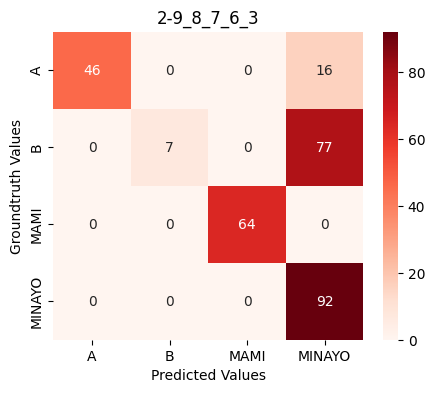

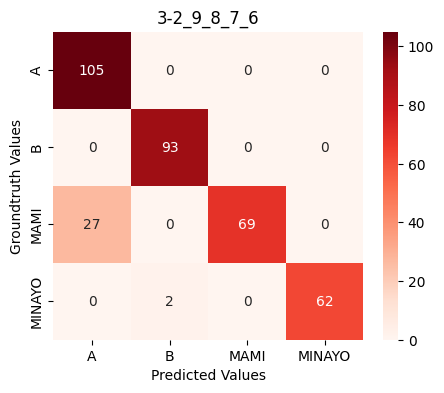

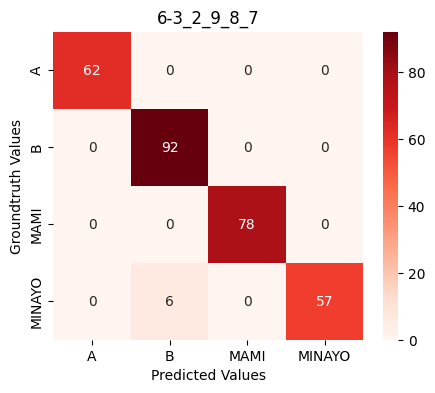

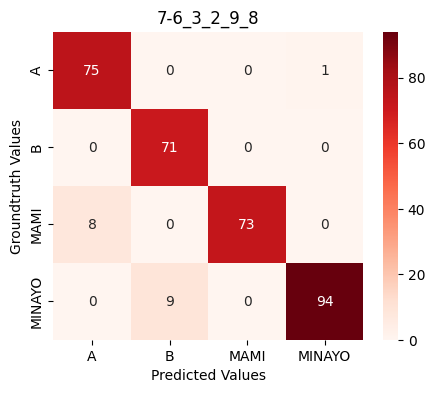

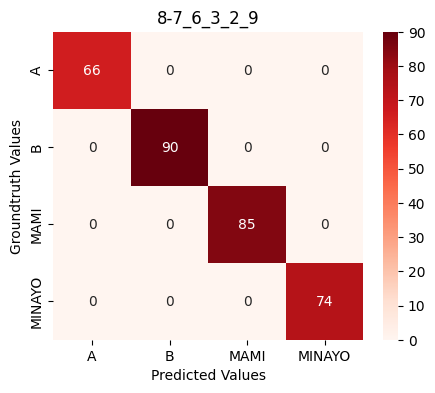

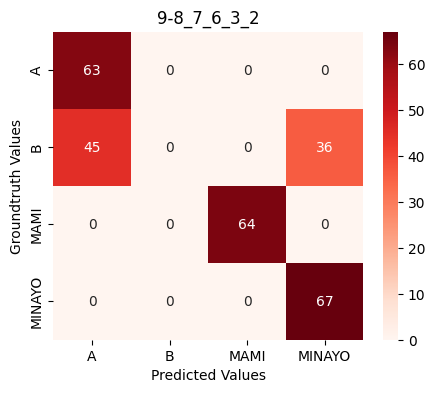

In [67]:
from sklearn.metrics import confusion_matrix

def calculate_confusion_matrix(df, num_classes=3):
    # Parse
    y_test = df['Dummy Class'].values
    y_pred = df.loc[:, [f'Class_{c}_score' for c in range(num_classes)]].to_numpy().argmax(axis=1)

    return confusion_matrix(y_test, y_pred, labels=np.arange(num_classes))

for score_csv, _ in sorted(csv_fpaths, key=lambda x:x[1]):
    df = pd.read_csv(score_csv)
    round_id = re.search(r'\d+-(\d+_){4,10}\d+', score_csv).group()

    # confusion matrix
    cm = calculate_confusion_matrix(df, n_classes)

    # df
    cm_df = pd.DataFrame(cm,
        index=[f'{class_2_dummy[c]}' for c in range(n_classes)],
        columns=[f'{class_2_dummy[c]}' for c in range(n_classes)])

    plt.figure(figsize=(5,4))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap=plt.cm.Reds)
    plt.title(round_id)
    plt.ylabel('Groundtruth Values')
    plt.xlabel('Predicted Values')
    plt.show()

# 2. Accuracy

In [68]:
def calculate_accuracy(df, num_classes=3, average='macro'):
    assert average in [None, 'micro', 'macro', 'weighted']
    y_test = df['label'].values
    y_pred = df.loc[:, [f'Class_{c}_score' for c in range(num_classes)]] \
        .to_numpy().argmax(axis=1)

    # accuracy, precision, recall, f1-score
    acc = metrics.accuracy_score(
        y_true=y_test,
        y_pred=y_pred, normalize=True)

    p = metrics.precision_score(
        y_true=y_test,
        y_pred=y_pred, average=average)

    r = metrics.recall_score(
        y_true=y_test,
        y_pred=y_pred, average=average)

    f1 = metrics.f1_score(
        y_true=y_test,
        y_pred=y_pred, average=average)

    return acc, p, r, f1

In [69]:
tmp = []
cols = ['ID', 'Accuracy', 'Precision', 'Recall', 'F1']
for score_csv, _ in sorted(csv_fpaths, key=lambda x:x[1]):
    df = pd.read_csv(score_csv)
    df['label'] = df['Dummy Class']
    round_id = re.search(r'\d+-(\d+_){4,10}\d+', score_csv).group()

    acc, p, r, f1 = calculate_accuracy(df, n_classes)
    # acc = np.mean(list(acc.values()))
    print(f'{round_id}')
    print(f"\tAccuracy: {acc:.3f}")
    print(f"\tPrecision: {p:.3f}")
    print(f"\tRecall: {r:.3f}")
    print(f"\tF1: {f1:.3f}")
    tmp.append( [
        round_id,
        round(acc, 3),
        round(p, 3),
        round(r, 3),
        round(f1, 3)] )

tmp_df = pd.DataFrame(tmp, columns=cols)
print(f"Accuracy: {tmp_df['Accuracy'].mean():.3f} +- {tmp_df['Accuracy'].std():.3f}")
print(f"Precision: {tmp_df['Precision'].mean():.3f} +- {tmp_df['Precision'].std():.3f}")
print(f"Recall: {tmp_df['Recall'].mean():.3f} +- {tmp_df['Recall'].std():.3f}")
print(f"F1: {tmp_df['F1'].mean():.3f} +- {tmp_df['F1'].std():.3f}")

tmp_df.to_excel("tmp.xlsx",
    sheet_name='Sheet1',
    columns=cols)

2-9_8_7_6_3
	Accuracy: 0.692
	Precision: 0.874
	Recall: 0.706
	F1: 0.667
3-2_9_8_7_6
	Accuracy: 0.919
	Precision: 0.944
	Recall: 0.922
	F1: 0.924
6-3_2_9_8_7
	Accuracy: 0.980
	Precision: 0.985
	Recall: 0.976
	F1: 0.980
7-6_3_2_9_8
	Accuracy: 0.946
	Precision: 0.945
	Recall: 0.950
	F1: 0.945
8-7_6_3_2_9
	Accuracy: 1.000
	Precision: 1.000
	Recall: 1.000
	F1: 1.000
9-8_7_6_3_2
	Accuracy: 0.705
	Precision: 0.558
	Recall: 0.750
	F1: 0.631
Accuracy: 0.874 +- 0.139
Precision: 0.884 +- 0.166
Recall: 0.884 +- 0.124
F1: 0.858 +- 0.164


/home/dangkhoadl/anaconda3/envs/dl-audio/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# 3. AUC

In [70]:
def calculate_auc_ovr(df, num_classes=3):
    fpr, tpr, threshold = dict(), dict(), dict()
    roc_auc_ovr = dict()

    # plot
    plt.figure(figsize=(20, 10))

    for c in range(num_classes):
        # Convert to binary classification
        df_aux = pd.DataFrame()
        df_aux['y_true'] = df['label'].apply(lambda x: 1 if x==c else 0)
        df_aux['y_hat'] = df[f'Class_{c}_score']

        # Compute auc
        fpr[c], tpr[c], threshold[c] = roc_curve(
            y_true=df_aux['y_true'],
            y_score=df_aux['y_hat'])
        roc_auc_ovr[c] = auc(x=fpr[c], y=tpr[c])

        # Plot probability distribution current class vs rest
        ax_top = plt.subplot(2, num_classes, c+1)
        sns.histplot(data=df_aux,
            x='y_hat', hue='y_true',
            color='b', ax=ax_top, bins=50)
        ax_top.set_title(c)
        ax_top.legend([f"Class: {c}", "Rest"])
        ax_top.set_xlabel(f"P(x = {c})")

        # Plots the ROC Curves
        ax_bottom = plt.subplot(2, num_classes, c+num_classes+1)
        plt.plot(fpr[c], tpr[c], label='ROC curve class %d (area = %0.2f)' % (c, roc_auc_ovr[c]))
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([-0.05, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")

    return fpr, tpr, roc_auc_ovr

In [71]:
def calculate_auc_ovo(df, num_classes=3):
    roc_auc_ovo = dict()
    fpr, tpr, threshold = dict(), dict(), dict()
    
    # plot
    plt.figure(figsize=(20, 15))
    
    # permutations
    classes_permutations = list(permutations(np.arange(num_classes), 2))
    N = len(classes_permutations)

    for i, (c1, c2) in enumerate(classes_permutations):
        title = f"Class {c1} vs Class {c2}"
        df_aux = pd.DataFrame()
        df_aux['label'] = df['label']
        df_aux['y_hat'] = df[f'Class_{c1}_score']
        
        # Slices only the subset with both classes
        df_aux = df_aux[
            (df_aux['label'] == c1) | (df_aux['label'] == c2)]

        # Convert to Binary Classification
        df_aux['y_true'] = df_aux['label'].apply(lambda x: 1 if x==c1 else 0)
        df_aux = df_aux.reset_index(drop = True)

        # Compute auc
        fpr[title], tpr[title], threshold[title] = roc_curve(
            y_true=df_aux['y_true'],
            y_score=df_aux['y_hat'])
        roc_auc_ovo[title] = auc(x=fpr[title], y=tpr[title])

        # Plots the probability distribution for c1 vs c2
        ax_top = plt.subplot(2, N, i+1)
        sns.histplot(data=df_aux,
             x='y_hat', hue='y_true',
            color='b', ax=ax_top, bins=20)
        ax_top.set_title(title)
        ax_top.legend([f"Class {c1}", f"Class {c2}"])
        ax_top.set_xlabel(f"P(x = {c1})")

        # Plots the ROC Curves
        ax_bottom = plt.subplot(2, N, i+N+1)
        plt.plot(fpr[title], tpr[title])
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([-0.05, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f"ROC curve {title} \n(area = {roc_auc_ovo[title]:.2f})")

    return fpr, tpr, roc_auc_ovo

In [72]:
df_s = []
for score_csv, _ in sorted(csv_fpaths, key=lambda x:x[1]):
    df_s.append(pd.read_csv(score_csv))
df = pd.concat(df_s, ignore_index=True)

{0: 0.9843806924586308, 1: 0.8978631283915042, 2: 1.0, 3: 0.9760340191892929}
Average per-class AUC OvR: 0.96


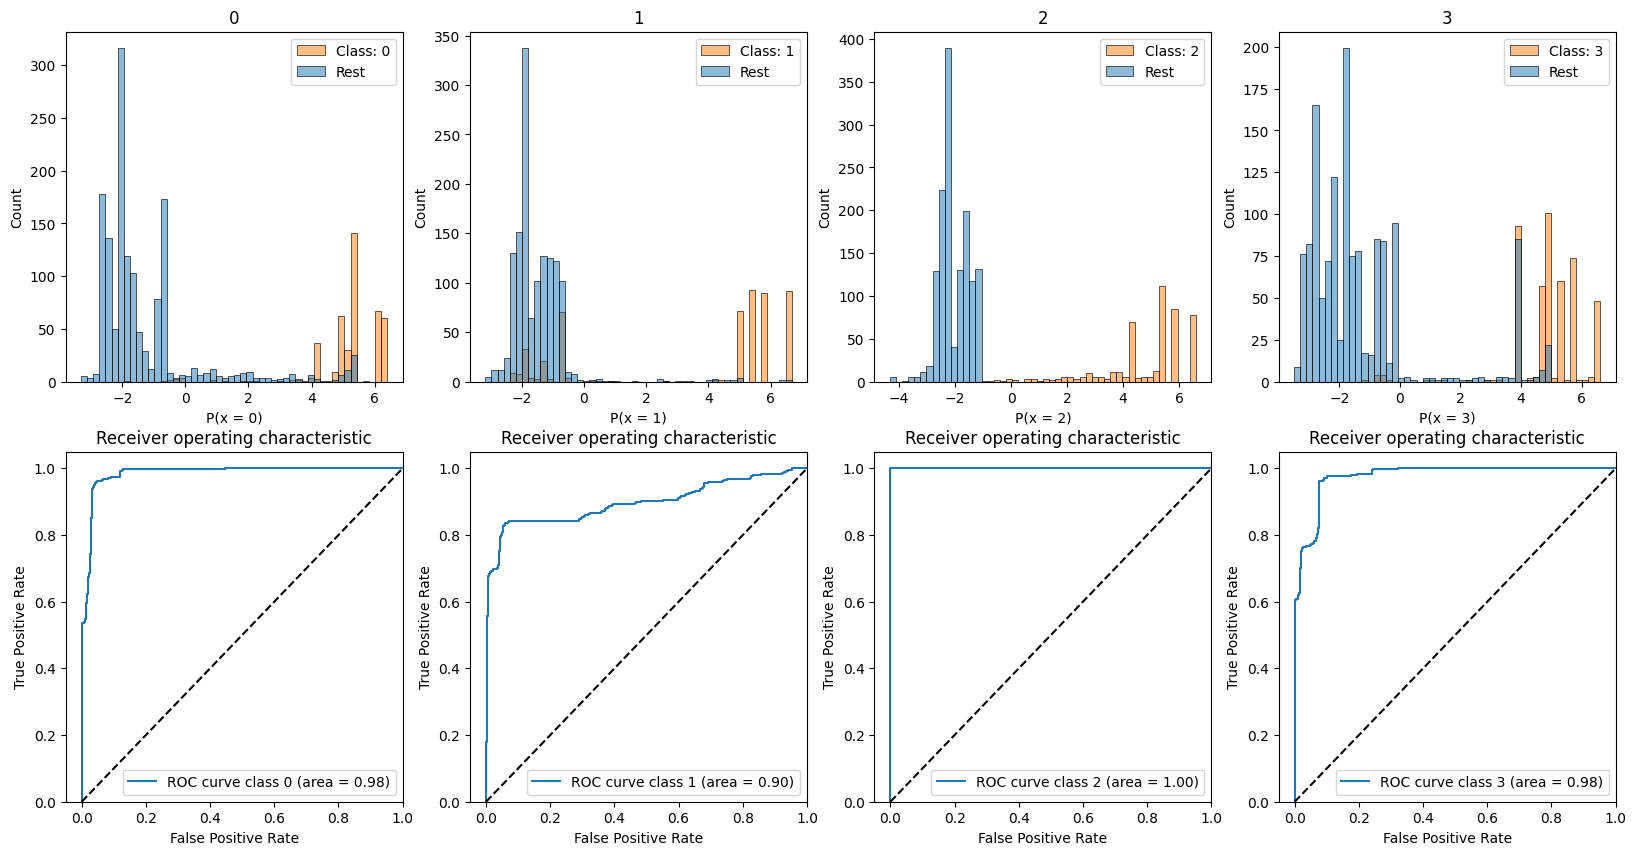

In [73]:
fpr, tpr, roc_auc = calculate_auc_ovr(df, n_classes)
pprint(roc_auc)
print(f"Average per-class AUC OvR: {np.mean(list(roc_auc.values())):.2f}")

{'Class 0 vs Class 1': 0.9696808462669204,
 'Class 0 vs Class 2': 0.9858304777659617,
 'Class 0 vs Class 3': 0.9991390550507111,
 'Class 1 vs Class 0': 0.9067519186198564,
 'Class 1 vs Class 2': 0.964532423436533,
 'Class 1 vs Class 3': 0.8221418216092615,
 'Class 2 vs Class 0': 1.0,
 'Class 2 vs Class 1': 1.0,
 'Class 2 vs Class 3': 1.0,
 'Class 3 vs Class 0': 0.9964417593136328,
 'Class 3 vs Class 1': 0.9367521439772097,
 'Class 3 vs Class 2': 1.0}
Average per-class AUC OvO: 0.9651058705033405


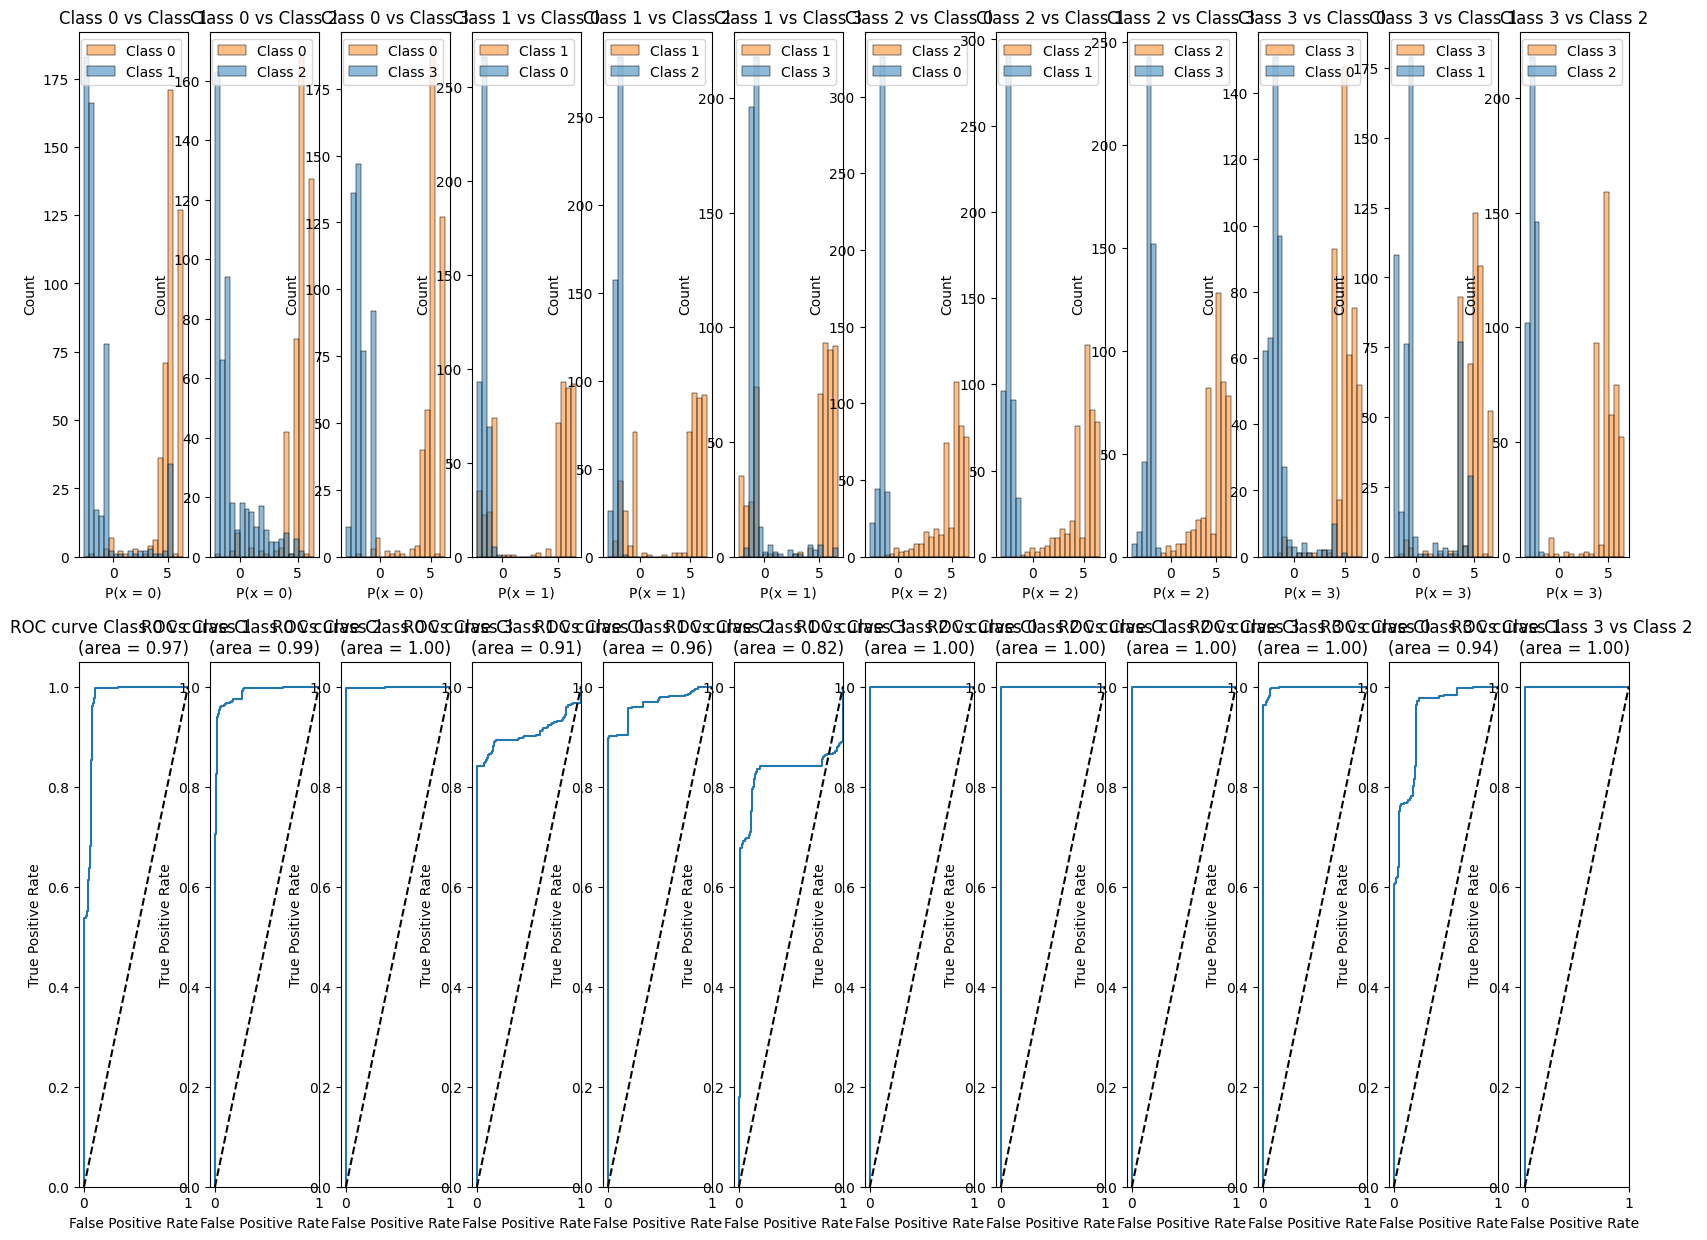

In [74]:
fpr, tpr, roc_auc = calculate_auc_ovo(df, n_classes)
pprint(roc_auc)
print("Average per-class AUC OvO:", np.mean(list(roc_auc.values())))